<a href="https://colab.research.google.com/github/TheReallyBigApple/CunyAssignments/blob/main/Data604/salmon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                       CUNY MSDS Data604 Week 5
#                            Tom Buonora

# Modeling and Simulation in Python

Case Study: Predicting salmon returns

This case study is based on a ModSim student project by Josh Deng and Erika Lu.

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [ ]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Can we predict salmon populations?

Each year the [U.S. Atlantic Salmon Assessment Committee](https://www.nefsc.noaa.gov/USASAC/Reports/USASAC2018-Report-30-2017-Activities.pdf) reports estimates of salmon populations in oceans and rivers in the northeastern United States.  The reports are useful for monitoring changes in these populations, but they generally do not include predictions.

The goal of this case study is to model year-to-year changes in population, evaluate how predictable these changes are, and estimate the probability that a particular population will increase or decrease in the next 10 years.

As an example, I'll use data from page 18 of the 2017 report, which provides population estimates for the Narraguagus and Sheepscot Rivers in Maine.

![USASAC_Report_2017_Page18](data/USASAC_Report_2017_Page18.png)

At the end of this notebook, I make some suggestions for extracting data from a PDF document automatically, but for this example I will keep it simple and type it in.

Here are the population estimates for the Narraguagus River:

In [ ]:
pops = [2749, 2845, 4247, 1843, 2562, 1774, 1201, 1284, 1287, 2339, 1177, 962, 1176, 2149, 1404, 969, 1237, 1615, 1201];

To get this data into a Pandas Series, I'll also make a range of years to use as an index.

In [ ]:
years = range(1997, 2016)

range(1997, 2016)

And here's the series.

In [ ]:
pop_series = TimeSeries(pops, index=years, dtype=np.float64)

,values
1997,2749.0
1998,2845.0
1999,4247.0
2000,1843.0
2001,2562.0
2002,1774.0
2003,1201.0
2004,1284.0
2005,1287.0
2006,2339.0


Here's what it looks like:

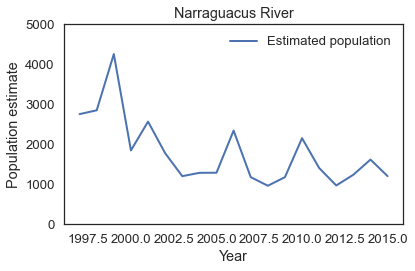

In [ ]:
def plot_population(series):
    plot(series, label='Estimated population')
    decorate(xlabel='Year', 
             ylabel='Population estimate', 
             title='Narraguacus River',
             ylim=[0, 5000])
    
plot_population(pop_series)

## Modeling changes

To see how the population changes from year-to-year, I'll use `ediff1d` to compute the absolute difference between each year and the next.


In [ ]:
abs_diffs = np.ediff1d(pop_series, to_end=0)

array([   96.,  1402., -2404.,   719.,  -788.,  -573.,    83.,     3.,
        1052., -1162.,  -215.,   214.,   973.,  -745.,  -435.,   268.,
         378.,  -414.,     0.])

We can compute relative differences by dividing by the original series elementwise.

In [ ]:
rel_diffs = abs_diffs / pop_series

1997    0.034922
1998    0.492794
1999   -0.566047
2000    0.390125
2001   -0.307572
2002   -0.322999
2003    0.069109
2004    0.002336
2005    0.817405
2006   -0.496794
2007   -0.182668
2008    0.222453
2009    0.827381
2010   -0.346673
2011   -0.309829
2012    0.276574
2013    0.305578
2014   -0.256347
2015    0.000000
dtype: float64

Or we can use the `modsim` function `compute_rel_diff`:

In [ ]:
rel_diffs = compute_rel_diff(pop_series)

1997    0.034922
1998    0.492794
1999   -0.566047
2000    0.390125
2001   -0.307572
2002   -0.322999
2003    0.069109
2004    0.002336
2005    0.817405
2006   -0.496794
2007   -0.182668
2008    0.222453
2009    0.827381
2010   -0.346673
2011   -0.309829
2012    0.276574
2013    0.305578
2014   -0.256347
2015    0.000000
dtype: float64

These relative differences are observed annual net growth rates.  So let's drop the `0` and save them.

In [ ]:
rates = rel_diffs.drop(2015)

1997    0.034922
1998    0.492794
1999   -0.566047
2000    0.390125
2001   -0.307572
2002   -0.322999
2003    0.069109
2004    0.002336
2005    0.817405
2006   -0.496794
2007   -0.182668
2008    0.222453
2009    0.827381
2010   -0.346673
2011   -0.309829
2012    0.276574
2013    0.305578
2014   -0.256347
dtype: float64

A simple way to model this system is to draw a random value from this series of observed rates each year.  We can use the NumPy function `choice` to make a random choice from a series.

In [ ]:
np.random.choice(rates)

0.27657378740970073

## Simulation

Now we can simulate the system by drawing random growth rates from the series of observed rates.

I'll start the simulation in 2015.

In [ ]:
t_0 = 2015
p_0 = pop_series[t_0]

1201.0

Create a `System` object with variables `t_0`, `p_0`, `rates`, and `duration=10` years. 

The series of observed rates is one big parameter of the model.

In [ ]:
system = System(t_0=t_0,
                p_0=p_0,
                duration=10,
                rates=rates)

,values
t_0,2015
p_0,1201
duration,10
rates,1997 0.034922 1998 0.492794 1999 -0.56...


Write an update functon that takes as parameters `pop`, `t`, and `system`.
It should choose a random growth rate, compute the change in population, and return the new population.

In [ ]:
def update_func1(pop, t, system):
    rand_rate = np.random.choice(system.rates)
    new_pop = pop * (1+ rand_rate)
           
    return new_pop

Test your update function and run it a few times

In [ ]:
update_func1(p_0, t_0, system)

1203.806074766355

Here's a version of `run_simulation` that stores the results in a `TimeSeries` and returns it.

In [ ]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    t_0 = system.t_0
    t_end = t_0 + system.duration
    
    results = TimeSeries()
    results[t_0] = system.p_0
    
    for t in linrange(t_0, t_end):
        results[t+1] = update_func(results[t], t, system)

    return results

Use `run_simulation` to run generate a prediction for the next 10 years.

The plot your prediction along with the original data.  Your prediction should pick up where the data leave off.

In [ ]:
run_simulation(system, update_func1)

,values
2015,1201.000000
2016,828.895299
2017,1506.438310
2018,1610.546869
2019,2102.694578
2020,3138.890641
2021,2173.455112
2022,1616.296960
2023,1055.970652
2024,458.242032


To get a sense of how much the results vary, we can run the model several times and plot all of the results.

In [ ]:
def plot_many_simulations(system, update_func, iters):
    """Runs simulations and plots the results.
    
    system: System object
    update_func: function object
    iters: number of simulations to run
    """
    for i in range(iters):
        results = run_simulation(system, update_func)
        plot(results, color='gray', linewidth=5, alpha=0.1)

The plot option `alpha=0.1` makes the lines semi-transparent, so they are darker where they overlap.

Run `plot_many_simulations` with your update function and `iters=30`.  Also plot the original data.

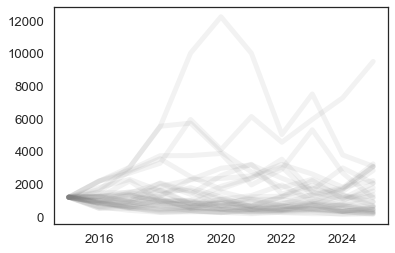

In [ ]:
plot_many_simulations(system, update_func1, 30)

The results are highly variable: according to this model, the population might continue to decline over the next 10 years, or it might recover and grow rapidly!

It's hard to say how seriously we should take this model.  There are many factors that influence salmon populations that are not included in the model.  For example, if the population starts to grow quickly, it might be limited by resource limits, predators, or fishing.  If the population starts to fall, humans might restrict fishing and stock the river with farmed fish.

So these results should probably not be considered useful predictions.  However, there might be something useful we can do, which is to estimate the probability that the population will increase or decrease in the next 10 years.  

## Distribution of net changes

To describe the distribution of net changes, write a function called `run_many_simulations` that runs many simulations, saves the final populations in a `ModSimSeries`, and returns the `ModSimSeries`.


In [ ]:

def run_many_simulations(system, update_func, iters):
    """Runs simulations and report final populations.
    
    system: System object
    update_func: function object
    iters: number of simulations to run
    
    returns: series of final populations
    """
    
    many_results = ModSimSeries()
    for i in range(iters):
        results = run_simulation(system, update_func)
        many_results[i]=results[results.index[-1]]
    return many_results
        

In [ ]:
run_many_simulations(system, update_func1, 4)

,values
0,568.502446
1,321.331043
2,3443.708071
3,1528.402952


Test your function by running it with `iters=5`.

In [ ]:
run_many_simulations(system, update_func1, 5)

,values
0,1471.053397
1,4037.670445
2,694.584948
3,2423.167007
4,14338.257778


Now we can run 1000 simulations and describe the distribution of the results.

In [ ]:
last_pops = run_many_simulations(system, update_func1, 1000)
last_pops.describe()

count     1000.000000
mean      1665.682041
std       3019.510472
min         18.769171
25%        293.789431
50%        724.980079
75%       1820.059202
max      47247.913436
dtype: float64

If we substract off the initial population, we get the distribution of changes.

In [ ]:
net_changes = last_pops - p_0
net_changes.describe()

count     1000.000000
mean       464.682041
std       3019.510472
min      -1182.230829
25%       -907.210569
50%       -476.019921
75%        619.059202
max      46046.913436
dtype: float64

The median is negative, which indicates that the population decreases more often than it increases.

We can be more specific by counting the number of runs where `net_changes` is positive.

In [ ]:
np.sum(net_changes > 0)

348

Or we can use `mean` to compute the fraction of runs where `net_changes` is positive.

In [ ]:
np.mean(net_changes > 0)

0.348

And here's the fraction where it's negative.

In [ ]:
np.mean(net_changes < 0)

0.652

So, based on observed past changes, this model predicts that the population is more likely to decrease than increase over the next 10 years, by about 2:1.

## A refined model

There are a few ways we could improve the model.

1.  It looks like there might be cyclic behavior in the past data, with a period of 4-5 years.  We could extend the model to include this effect.

2.  Older data might not be as relevant for prediction as newer data, so we could give more weight to newer data.

The second option is easier to implement, so let's try it.

I'll use `linspace` to create an array of "weights" for the observed rates.  The probability that I choose each rate will be proportional to these weights.

The weights have to add up to 1, so I divide through by the total.

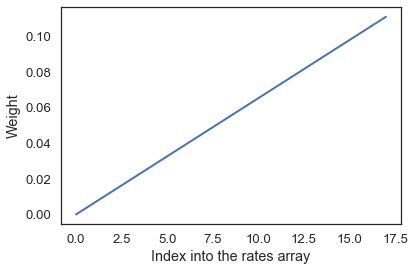

In [ ]:
weights = linspace(0, 1, len(rates))
weights /= sum(weights)
plot(weights)
decorate(xlabel='Index into the rates array',
         ylabel='Weight')

I'll add the weights to the `System` object, since they are parameters of the model.

In [ ]:
#  # weights is now 0 to .11 by about .0065 each
system.weights = weights

We can pass these weights as a parameter to `np.random.choice` (see the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html))

In [ ]:
np.random.choice(system.rates, p=system.weights)

0.3055780113177041

Write an update function that takes the weights into account.

In [ ]:
def update_func4(pop, t, system):
    rand_rate = np.random.choice(system.rates, p=system.weights)
    new_pop = pop * (1+ rand_rate)
           
    return new_pop

Use `plot_many_simulations` to plot the results.

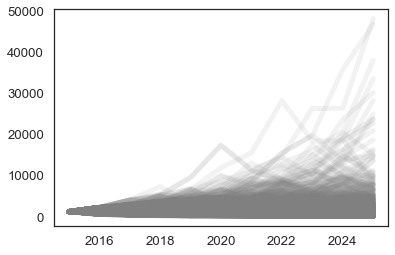

In [ ]:
plot_many_simulations(system, update_func4, 1000)

Use `run_many_simulations` to collect the results and `describe` to summarize the distribution of net changes.

In [ ]:
weighted_pops = run_many_simulations(system, update_func4, 1000)
weighted_pops.describe()

count     1000.000000
mean      1765.464204
std       3123.020802
min          9.904239
25%        344.599004
50%        860.850975
75%       1952.418326
max      45275.489194
dtype: float64

Does the refined model have much effect on the probability of population decline?

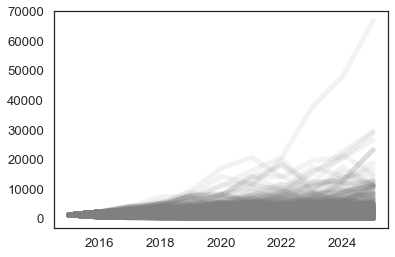

In [ ]:
plot_many_simulations(system, update_func1, 1000)

In [ ]:
non_weighted_pops = run_many_simulations(system, update_func1, 1000)
non_weighted_pops.describe()

count     1000.000000
mean      1806.987462
std       4010.523845
min         17.935018
25%        304.191923
50%        764.004722
75%       1830.150895
max      69859.888618
dtype: float64

<br><font color="purple">Hard to say since they both are random, but it does appear there is more variance from the extra weights</font><br>

## Extracting data from a PDF document

The following section uses `tabula-py` to get data from a PDF document.

If you don't already have it installed, and you are using Anaconda, you can install it by running the following command in a Terminal or Git Bash:

```
conda install -c conda-forge tabula-py
```

In [ ]:
from tabula import read_pdf

In [ ]:
df = read_pdf('C:\\Users\\arono\\CUNY\\DATA604_Python\\ModSimPy-master\\notebooks\\data\\USASAC2018-Report-30-2017-Activities-Page11.pdf')

'pages' argument isn't specified.Will extract only from page 1 by default.


[    Unnamed: 0   1 SW    2SW  3SW  Repeat  Total Hatchery  Natural
 0         1997    278  1,492    8      36  1,814    1,296      518
 1         1998    340  1,477    3      42  1,862    1,146      716
 2         1999    402  1,136    3      26  1,567      959      608
 3         2000    292    535    0      20    847      562      285
 4         2001    269    804    7       4  1,084      833      251
 5         2002    437    505    2      23    967      832      135
 6         2003    233  1,185    3       6  1,427    1,238      189
 7         2004    319  1,266   21      24  1,630    1,395      235
 8         2005    317    945    0      10  1,272    1,019      253
 9         2006    442  1,007    2       5  1,456    1,167      289
 10        2007    299    958    3       1  1,261      940      321
 11        2008    812  1,758   12      23  2,605    2,191      414
 12        2009    243  2,065   16      16  2,340    2,017      323
 13        2010    552  1,081    2      16  1,65